In [4]:
import pandas as pd
from sqlalchemy import create_engine

# Configure your database connection
db_host = 'localhost'
db_port = '5432'
db_name = 'tickvah_banks_ads'
db_user = 'postgres'
db_password = 'admin'

# Construct the database URL
db_url = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create the SQLAlchemy engine
engine = create_engine(db_url)

/usr/lib/python3.10/typing.py:1351: RuntimeWarning: coroutine 'main' was never awaited
  super().__init_subclass__(*args, **kwargs)


2024-05-22 11:26:05,478 - __main__ - INFO - Playstore Reviews Columns: reviewId, userName, userImage, content, score, reviewCreatedVersion, at, replyContent, repliedAt, appVersion
2024-05-22 11:26:05,479 - __main__ - INFO - Bank Ads Columns: date, post_link, view, post_hour, bank, time_of_day
2024-05-22 11:26:05,964 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 11:26:05,976 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-22 11:26:06,269 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriat

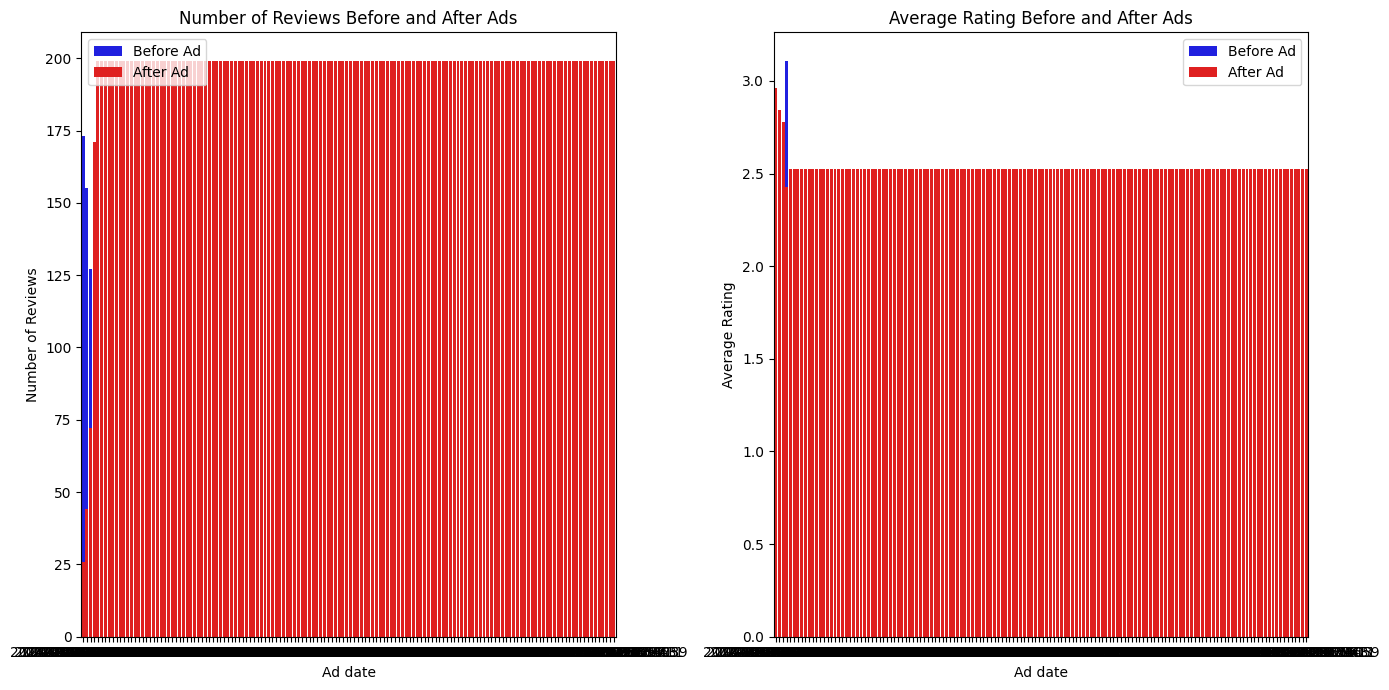

In [8]:
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
from db_connection import get_database_engine
import logging

# Configure logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# Function to load data from PostgreSQL
def load_data(engine):
    try:
        playstore_query = "SELECT * FROM playtore_reviews"
        ads_query = "SELECT * FROM bank_advertisements"
        
        playstore_reviews = pd.read_sql(playstore_query, engine)
        bank_ads = pd.read_sql(ads_query, engine)
        
        return playstore_reviews, bank_ads   
    except Exception as e:
        logger.error(f"Error occurred while loading data from PostgreSQL: {e}")
        return None, None



# Function to preprocess the data
def preprocess_data(playstore_reviews, bank_ads):
    logger.info("Playstore Reviews Columns: " + ", ".join(playstore_reviews.columns))
    logger.info("Bank Ads Columns: " + ", ".join(bank_ads.columns))
    
    # Convert columns to datetime
    playstore_reviews['at'] = pd.to_datetime(playstore_reviews['at'])
    bank_ads['date'] = pd.to_datetime(bank_ads['date'])

    return playstore_reviews, bank_ads

# Function to analyze the impact of ads
def analyze_impact(playstore_reviews, bank_ads):
    results = []
    for _, ad in bank_ads.iterrows():
        ad_date = ad['date']
        pre_ad_reviews = playstore_reviews[playstore_reviews['at'] < ad_date]
        post_ad_reviews = playstore_reviews[playstore_reviews['at'] >= ad_date]

        pre_ad_count = pre_ad_reviews.shape[0]
        post_ad_count = post_ad_reviews.shape[0]
        
        pre_ad_avg_rating = pre_ad_reviews['score'].mean()
        post_ad_avg_rating = post_ad_reviews['score'].mean()

        results.append({
            'ad_date': ad_date,
            'pre_ad_count': pre_ad_count,
            'post_ad_count': post_ad_count,
            'pre_ad_avg_rating': pre_ad_avg_rating,
            'post_ad_avg_rating': post_ad_avg_rating
        })

    return pd.DataFrame(results)


# Function to visualize the results
def visualize_results(results):
    plt.figure(figsize=(14, 7))
    
    # Plotting number of reviews before and after each ad
    plt.subplot(1, 2, 1)
    sns.barplot(x='ad_date', y='pre_ad_count', data=results, color='blue', label='Before Ad')
    sns.barplot(x='ad_date', y='post_ad_count', data=results, color='red', label='After Ad')
    plt.xlabel('Ad date')
    plt.ylabel('Number of Reviews')
    plt.title('Number of Reviews Before and After Ads')
    plt.legend()

    # Plotting average rating before and after each ad
    plt.subplot(1, 2, 2)
    sns.barplot(x='ad_date', y='pre_ad_avg_rating', data=results, color='blue', label='Before Ad')
    sns.barplot(x='ad_date', y='post_ad_avg_rating', data=results, color='red', label='After Ad')
    plt.xlabel('Ad date')
    plt.ylabel('Average Rating')
    plt.title('Average Rating Before and After Ads')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    engine = get_database_engine(db_name='tickvah_banks_ads', db_user='postgres', db_password='admin', db_host='localhost', db_port='5432')
    playstore_reviews, bank_ads = load_data(engine)
    
    if playstore_reviews is not None and bank_ads is not None:
        playstore_reviews, bank_ads = preprocess_data(playstore_reviews, bank_ads)
        results = analyze_impact(playstore_reviews, bank_ads)
        visualize_results(results)


In [10]:
print(results.head(10))  # Check the first few rows of the results DataFrame
print(results.columns)  # Check the columns of the results DataFrame


              ad_date  pre_ad_count  post_ad_count  pre_ad_avg_rating  \
0 2024-05-14 07:49:21           173             26           2.456647   
1 2024-05-10 13:39:46           155             44           2.432258   
2 2024-05-07 10:46:34           127             72           2.377953   
3 2024-04-30 17:01:34            28            171           3.107143   
4 2024-04-26 18:11:43             0            199                NaN   
5 2024-04-23 14:23:46             0            199                NaN   
6 2024-04-19 17:11:18             0            199                NaN   
7 2024-04-12 18:20:16             0            199                NaN   
8 2024-04-11 08:06:04             0            199                NaN   
9 2024-04-05 13:52:56             0            199                NaN   

   post_ad_avg_rating  
0            2.961538  
1            2.840909  
2            2.777778  
3            2.426901  
4            2.522613  
5            2.522613  
6            2.522613  
7   

In [12]:
import asyncio
import os
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from telethon import TelegramClient
from telethon.tl.functions.channels import GetFullChannelRequest
from db_connection import get_database_engine, close_connection

# Function to save data to a CSV file
def save_to_csv(data, filename):
    try:
        os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure directory exists
        if os.path.exists(filename):
            data.to_csv(filename, mode='a', header=False, index=False)  # Append to existing file without writing the header again
        else:
            data.to_csv(filename, index=False)
        print(f"Successfully saved data to {filename}")
    except Exception as e:
        print(f"Error occurred while saving data to CSV file: {e}")

# Function to fetch channel info
async def get_channel_info(api_id, api_hash, channel_username, date):
    try:
        async with TelegramClient('session_name', api_id, api_hash) as client:
            await client.start()
            channel = await client.get_entity(channel_username)
            full_channel = await client(GetFullChannelRequest(channel=channel))
            channel_info = {
                'date': date,
                'subscribers': full_channel.full_chat.participants_count
            }
            return channel_info
    except Exception as e:
        print(f"Error fetching channel info: {e}")
        return None

# Function to insert data into PostgreSQL
def insert_subscription_data(engine, data, table_name):
    try:
        data.to_sql(table_name, engine, if_exists='append', index=False)
        print(f"Data inserted successfully into the PostgreSQL table {table_name}")
    except Exception as e:
        print(f"Error occurred while inserting data into PostgreSQL: {e}")

# Main function to fetch daily and monthly subscription data
async def main():
    # Your Telegram API credentials
    api_id = '26622716'
    api_hash = 'fd4274717bfcacf787cc15b9b51f1c76'
    channel_username = 'BoAEth'
    
    # Database credentials
    db_name = 'tickvah_banks_ads'
    db_user = 'postgres'
    db_password = 'admin'
    db_host = 'localhost'
    db_port = '5432'
    
    # Connect to the database
    engine = get_database_engine(db_name, db_user, db_password, db_host, db_port)
    
    # Define the starting date and date range for data collection
    start_date = datetime(2017, 1, 1)
    end_date = datetime.now()
    
    # Fetch daily subscription data
    current_date = start_date
    daily_data = []
    while current_date <= end_date:
        channel_info = await get_channel_info(api_id, api_hash, channel_username, current_date)
        if channel_info:
            daily_data.append(channel_info)
        current_date += timedelta(days=1)
        
    # Convert to DataFrame and save daily data to CSV and database
    if daily_data:
        daily_df = pd.DataFrame(daily_data)
        save_to_csv(daily_df, 'data/raw/daily_telegram_subscriptions.csv')
        insert_subscription_data(engine, daily_df, 'daily_telegram_subscriptions')
    
    # Fetch monthly subscription data
    current_date = start_date
    monthly_data = []
    while current_date <= end_date:
        channel_info = await get_channel_info(api_id, api_hash, channel_username, current_date)
        if channel_info:
            monthly_data.append(channel_info)
        current_date += timedelta(days=30)  # Approximate monthly interval
    
    # Convert to DataFrame and save monthly data to CSV and database
    if monthly_data:
        monthly_df = pd.DataFrame(monthly_data)
        save_to_csv(monthly_df, 'data/raw/monthly_telegram_subscriptions.csv')
        insert_subscription_data(engine, monthly_df, 'monthly_telegram_subscriptions')
    
    # Close database connection
    close_connection(engine)

if __name__ == "__main__":
    asyncio.run(main())


RuntimeError: asyncio.run() cannot be called from a running event loop